In [1]:
from transformers import Swinv2Config, Swinv2Model, AutoFeatureExtractor
import transformers
import os, json, glob, requests, torch, cv2
import numpy as np
from PIL import Image
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from sklearn.metrics import accuracy_score
from tensorflow.keras.preprocessing import image
from transformers import Swinv2ForImageClassification

In [2]:
#set default path
TRAIN_JSON_PATH = r'C:\Users\User\Desktop\Code\Github\Final_project\data\label\train'
VALID_JSON_PATH = r'C:\Users\User\Desktop\Code\Github\Final_project\data\label\val'
TEST_JSON_PATH = r'C:\Users\User\Desktop\Code\Github\Final_project\data\label\test'

TRAIN_IMG_PATH = r'C:\Users\User\Desktop\Code\Github\Final_project\data\train'
VALID_IMG_PATH = r'C:\Users\User\Desktop\Code\Github\Final_project\data\val'
TEST_IMG_PATH = r'C:\Users\User\Desktop\Code\Github\Final_project\data\test'

TRAIN_SEGMENT_PATH = r'C:\Users\User\Desktop\Code\Github\Final_project\data\segmentation\train'
VALID_SEGMENT_PATH = r'C:\Users\User\Desktop\Code\Github\Final_project\data\segmentation\val'

MASKED_TRAIN_PATH = r'C:\Users\User\Desktop\Code\Github\Final_project\data\masked_train'
MASKED_VAL_PATH = r'C:\Users\User\Desktop\Code\Github\Final_project\data\masked_val'



IMG_ROWS = 256
IMG_COLS = 256

In [3]:
#To get json list that contains info about the pictures.
def get_json_list_1d(json_folder_path): #returns a 1 dim array
    temp_loader = []
    json_train = []
    emotion_list_json = os.listdir(json_folder_path)

    for emotion in emotion_list_json:
        with open (json_folder_path + "\\" + emotion, "r", encoding='euc-kr') as f:
            temp_loader.append(json.load(f))     

    for i in range(len(temp_loader)):
        json_train += temp_loader[i]     

    return json_train

def get_json_list_2d(json_folder_path): #returns 2 dim array
    json_train = []
    emotion_list_json = os.listdir(json_folder_path)

    for emotion in emotion_list_json:
        with open (json_folder_path + emotion, "r", encoding='euc-kr') as f:
            json_train.append(json.load(f))     

    return json_train



Json 파일들을 읽기 쉽게 불러오기

In [5]:
#call for the functions
json_train = get_json_list_1d(TRAIN_JSON_PATH)
json_val = get_json_list_1d(VALID_JSON_PATH)




print(json_train[0].keys()) #see what keys are available
print(len(json_train))
print(len(json_val))
print(os.listdir(TRAIN_IMG_PATH))
#0 = 분노, 1 = 기쁨, 2 = 당황, 3 = 슬픔
#0 = anger, 1 = happy, 2 = panic, 3 = sadness


dict_keys(['filename', 'gender', 'age', 'isProf', 'faceExp_uploader', 'bg_uploader', 'annot_A', 'annot_B', 'annot_C'])
5382
1049
['anger', 'happy', 'panic', 'sadness']


In [35]:
# print(len(json_val_2d[1]))
# len(json_train)
print(len(os.listdir(VALID_IMG_PATH + '/' + 'happy/')))

303


파일 JSON 이랑 비교해서 빠진거 있나 확인

In [13]:
#여기는 2D 쪽을 사용해서 했었음

# filenames_json = [entry['filename'] for entry in json_val_2d[1]]
# filenames_folder = os.listdir(VALID_IMG_PATH + 'happy/')

# print(list( set(filenames_json) - set(filenames_folder)))
# print(len(list( set(filenames_json) - set(filenames_folder))))

[]
0


In [14]:
#checking if that file exist in the path
# temp = r'C:\Users\User\Downloads\Project3\val\happy'
# filenames_folder = os.listdir(temp)

# '7uji1c8ab7778bc286c3cd90077847f9a906f00b210838ba57877a29abd60ffix.jpg' in filenames_folder

False

get all images and put them into a list

In [6]:
#0 = 분노, 1 = 기쁨, 2 = 당황, 3 = 슬픔


#이미지와 레이블을 받아오기. 이미지 리사이즈만 하고 다른 전처리는 안함
#다른 전처리도 같이 진행 가능함. 아래에서 feature_extractor 에서 모델에 맞는 전처리를 해주기 때문에 여기서 진행 안함.

#designed for 1D json file
def load_image_and_label_1D(json_list, img_path):
    img_file = []
    label_list = []
    
    eng_to_num = { '분노'   : '0',
                   '기쁨'   : '1',
                   '당황'   : '2',
                   '슬픔'   : '3'             
                 }
    kr_to_en = { '분노'    : 'anger',
                 '기쁨'   : 'happy',
                 '당황'   : 'panic',
                 '슬픔'   : 'sadness'             
                 }

    
    for entry in range(len(json_list)):
        try:
            label = json_list[entry]['faceExp_uploader']
            img_dir = img_path + '/' + kr_to_en[label] + '/' + json_list[entry]['filename']
            # img_dir = img_path + kr_to_en[label] + '/' + json_list[entry]['filename']
            # img = np.array(image.load_img(img_dir, target_size=(IMG_ROWS, IMG_COLS)))/255
            img = image.load_img(img_dir, target_size=(IMG_ROWS, IMG_COLS))
            img_file.append(img)
            label_list.append(int(eng_to_num[label]))
        except Exception:
            print("Emotion " + label + " " + json_list[entry]['filename'] + " Not available")
            pass

    return img_file, label_list

In [31]:
train_img, train_label = load_image_and_label_1D(json_train, TRAIN_IMG_PATH)
# train_img, train_label = load_image_and_label_1D(json_train, MASKED_TRAIN_PATH)

Emotion 당황 twdva8d723865fa1005873a6967797c75f3dd83197f13f7daa3e3926947071al6.jpg Not available
Emotion 당황 5yid6d7ae32bf14b1343da46cfdb3fdffc8e1c64baf4fb1b175690f648a870v69.jpg Not available
Emotion 당황 bpv531e5cebdb1c00085158bb0677c5596ccabf1c8a5cb0007991571bf306wcd4.jpg Not available
Emotion 당황 s1q397a38900c1e1f950496109900e7c01f0630459790d8590010655c4090vlh0.jpg Not available
Emotion 당황 7m2k46c05803855399ea1ee1911875ee59e05640c93135c0bc91b5660456cdo8k.jpg Not available
Emotion 당황 n55yc741f09701506c7eb5ba30533db35c905ab5bf0597b5652ece03c5950ozv1.jpg Not available
Emotion 당황 bid7b3c93409e1d83514689337f6d3d63a338339d71c9ce7fded153d3576fk2ml.jpg Not available
Emotion 당황 if0lfc4b517c6597e3656dbea350e406e1b5ae4e175e460597064875909d9t40p.jpg Not available
Emotion 당황 58w153f3f5ade2ad20ec19e6744ff2ff0a54ba3520ffbef36f3f3a47af75fxuf5.jpg Not available
Emotion 당황 lhyp01dff4faf13d1b4319722dc31bb3a104a3878ab3816a03bb8acdfa3d3eomk.jpg Not available
Emotion 당황 vba0d31d23b44711180462388c8aba4424a0aa2

In [30]:
# val_img, val_label = load_image_and_label_1D(json_val, VALID_IMG_PATH)
val_img, val_label = load_image_and_label_1D(json_val, VALID_IMG_PATH)

In [12]:
print(len(train_img))
# print(type(train_label[0]))
print(len(val_img))
# print(train_img[0].shape)
# print(len(test_img))

5364
1049


Modeling

In [7]:
from transformers import Swinv2ForImageClassification, AutoFeatureExtractor

In [10]:
model_name = "microsoft/swinv2-tiny-patch4-window8-256"


In [28]:
train_df = pd.DataFrame(columns=['image', 'label'])
train_df['image'] = train_img
train_df['label'] = train_label

val_df = pd.DataFrame(columns=['image', 'label'])
val_df['image'] = val_img
val_df['label'] = val_label



NameError: name 'train_img' is not defined

In [44]:
train_dict = train_df.to_dict('records')
val_dict = val_df.to_dict('records')


# train_dict[0]['image']
# train_dict
# print(type(train_dict[0]))

In [45]:
from datasets import Dataset
# train_ds = Dataset.from_pandas(pd.DataFrame(data=train_dict))
train_ds = Dataset.from_list(train_dict)
val_ds = Dataset.from_list(val_dict)

train_ds

Dataset({
    features: ['image', 'label'],
    num_rows: 5364
})

In [8]:
# label2id = {       '분노'   : '0',
#                    '기쁨'   : '1',
#                    '당황'   : '2',
#                    '슬픔'   : '3'             
#                  }
# id2label = {
#     '0' : '분노',
#     '1' : '기쁨',
#     '2' : '당황',
#     '3' : '슬픔'
# }

label2id = {       'Anger'   : '0',
                   'Happy'   : '1',
                   'Panic'   : '2',
                   'Sadness'   : '3'             
                 }
id2label = {
    '0' : 'Anger',
    '1' : 'Happy',
    '2' : 'Panic',
    '3' : 'Sadness'
}

id2label

{'0': '분노', '1': '기쁨', '2': '당황', '3': '슬픔'}

In [11]:
from transformers import AutoImageProcessor

image_processor  = AutoImageProcessor.from_pretrained(model_name)
image_processor

c:\Users\User\anaconda3\envs\my_env_py311\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


ViTImageProcessor {
  "_valid_processor_keys": [
    "images",
    "do_resize",
    "size",
    "resample",
    "do_rescale",
    "rescale_factor",
    "do_normalize",
    "image_mean",
    "image_std",
    "return_tensors",
    "data_format",
    "input_data_format"
  ],
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 256,
    "width": 256
  }
}

In [12]:
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    Resize,
    ToTensor,
)

normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
if "height" in image_processor.size:
    size = (image_processor.size["height"], image_processor.size["width"])
    crop_size = size
    max_size = None
elif "shortest_edge" in image_processor.size:
    size = image_processor.size["shortest_edge"]
    crop_size = (size, size)
    max_size = image_processor.size.get("longest_edge")

train_transforms = Compose(
        [
            RandomResizedCrop(crop_size),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

val_transforms = Compose(
        [
            Resize(size),
            CenterCrop(crop_size),
            ToTensor(),
            normalize,
        ]
    )

def preprocess_train(example_batch):
    """Apply train_transforms across a batch."""
    example_batch["pixel_values"] = [train_transforms(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch

def preprocess_val(example_batch):
    """Apply val_transforms across a batch."""
    example_batch["pixel_values"] = [val_transforms(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch

In [49]:
train_ds.set_transform(preprocess_train)
val_ds.set_transform(preprocess_val)


In [20]:
train_ds[0]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=256x256>,
 'label': 0,
 'pixel_values': tensor([[[-1.1075, -1.1418, -1.1247,  ..., -1.0733, -1.0390, -1.0904],
          [-1.1247, -1.1247, -1.1075,  ..., -1.0904, -1.0562, -1.0733],
          [-1.1075, -1.1075, -1.1075,  ..., -1.1075, -1.0733, -1.0904],
          ...,
          [-0.1486, -0.1486, -0.1314,  ...,  0.9132,  0.9303,  0.9303],
          [-0.0116, -0.0287,  0.0227,  ...,  0.9132,  0.9132,  0.9132],
          [ 0.1768,  0.1426,  0.1939,  ...,  0.9303,  0.9303,  0.8961]],
 
         [[-0.7227, -0.7577, -0.7577,  ..., -0.7402, -0.7052, -0.7577],
          [-0.7402, -0.7402, -0.7402,  ..., -0.7227, -0.6877, -0.7227],
          [-0.7227, -0.7227, -0.7402,  ..., -0.7227, -0.6877, -0.7227],
          ...,
          [-0.0049, -0.0049,  0.0126,  ...,  1.2031,  1.2206,  1.2206],
          [ 0.1527,  0.1176,  0.1702,  ...,  1.2206,  1.2206,  1.2206],
          [ 0.3277,  0.2927,  0.3452,  ...,  1.2381,  1.2381,  1.2556]],


In [50]:
model = Swinv2ForImageClassification.from_pretrained(
    model_name, 
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes = True, # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
)

Some weights of Swinv2ForImageClassification were not initialized from the model checkpoint at microsoft/swinv2-tiny-patch4-window8-256 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([4]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [51]:
from transformers import TrainingArguments, Trainer

batch_size = 8

model_checkpoint = model_name.split("/")[-1]

args = TrainingArguments(
    f"{model_checkpoint}-finetuned-emotions-train-masked",
    remove_unused_columns=False,
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=30,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    # push_to_hub=True,
)

In [52]:
import numpy as np

# the compute_metrics function takes a Named Tuple as input:
# predictions, which are the logits of the model as Numpy arrays,
# and label_ids, which are the ground-truth labels as Numpy arrays.
def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

In [53]:
import torch

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

In [28]:
from huggingface_hub import login

login()

In [54]:
from datasets import load_metric

metric = load_metric("accuracy")

c:\Users\User\anaconda3\envs\my_env_py311\Lib\site-packages\datasets\load.py:759: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [55]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)

In [56]:
train_results = trainer.train()
# rest is optional but nice to have
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

  0%|          | 0/5010 [00:00<?, ?it/s]

{'loss': 1.4173, 'grad_norm': 4.963411808013916, 'learning_rate': 9.980039920159682e-07, 'epoch': 0.06}
{'loss': 1.3894, 'grad_norm': 6.791276931762695, 'learning_rate': 1.9960079840319363e-06, 'epoch': 0.12}
{'loss': 1.3966, 'grad_norm': 6.7818145751953125, 'learning_rate': 2.9940119760479042e-06, 'epoch': 0.18}
{'loss': 1.3717, 'grad_norm': 4.816768169403076, 'learning_rate': 3.992015968063873e-06, 'epoch': 0.24}
{'loss': 1.3771, 'grad_norm': 5.76188850402832, 'learning_rate': 4.9900199600798405e-06, 'epoch': 0.3}
{'loss': 1.379, 'grad_norm': 7.152700901031494, 'learning_rate': 5.9880239520958085e-06, 'epoch': 0.36}
{'loss': 1.3758, 'grad_norm': 5.186458587646484, 'learning_rate': 6.986027944111776e-06, 'epoch': 0.42}
{'loss': 1.36, 'grad_norm': 6.5703229904174805, 'learning_rate': 7.984031936127745e-06, 'epoch': 0.48}
{'loss': 1.3223, 'grad_norm': 6.3045172691345215, 'learning_rate': 8.982035928143713e-06, 'epoch': 0.54}
{'loss': 1.305, 'grad_norm': 8.671656608581543, 'learning_rate

  0%|          | 0/132 [00:00<?, ?it/s]

{'eval_loss': 1.3025370836257935, 'eval_accuracy': 0.3794089609151573, 'eval_runtime': 5.9108, 'eval_samples_per_second': 177.473, 'eval_steps_per_second': 22.332, 'epoch': 1.0}
{'loss': 1.1267, 'grad_norm': 11.08442497253418, 'learning_rate': 1.6966067864271457e-05, 'epoch': 1.01}
{'loss': 0.9779, 'grad_norm': 11.546260833740234, 'learning_rate': 1.7964071856287426e-05, 'epoch': 1.07}
{'loss': 1.0095, 'grad_norm': 16.48371124267578, 'learning_rate': 1.8962075848303393e-05, 'epoch': 1.13}
{'loss': 0.952, 'grad_norm': 8.521121978759766, 'learning_rate': 1.9960079840319362e-05, 'epoch': 1.19}
{'loss': 0.8605, 'grad_norm': 12.767341613769531, 'learning_rate': 2.095808383233533e-05, 'epoch': 1.25}
{'loss': 0.9728, 'grad_norm': 17.146793365478516, 'learning_rate': 2.1956087824351298e-05, 'epoch': 1.31}
{'loss': 0.8467, 'grad_norm': 19.384918212890625, 'learning_rate': 2.2954091816367264e-05, 'epoch': 1.37}
{'loss': 0.8787, 'grad_norm': 11.692898750305176, 'learning_rate': 2.3952095808383234

  0%|          | 0/132 [00:00<?, ?it/s]

{'eval_loss': 1.0413624048233032, 'eval_accuracy': 0.5700667302192565, 'eval_runtime': 5.7461, 'eval_samples_per_second': 182.559, 'eval_steps_per_second': 22.972, 'epoch': 2.0}
{'loss': 0.7123, 'grad_norm': 11.29297924041748, 'learning_rate': 3.393213572854291e-05, 'epoch': 2.03}
{'loss': 0.8164, 'grad_norm': 8.674234390258789, 'learning_rate': 3.4930139720558886e-05, 'epoch': 2.09}
{'loss': 0.8083, 'grad_norm': 14.92780876159668, 'learning_rate': 3.592814371257485e-05, 'epoch': 2.15}
{'loss': 0.8495, 'grad_norm': 9.481246948242188, 'learning_rate': 3.692614770459082e-05, 'epoch': 2.21}
{'loss': 0.7223, 'grad_norm': 13.61283016204834, 'learning_rate': 3.7924151696606785e-05, 'epoch': 2.27}
{'loss': 0.6644, 'grad_norm': 11.804389953613281, 'learning_rate': 3.892215568862276e-05, 'epoch': 2.32}
{'loss': 0.6461, 'grad_norm': 8.117280006408691, 'learning_rate': 3.9920159680638724e-05, 'epoch': 2.38}
{'loss': 0.6646, 'grad_norm': 8.45789909362793, 'learning_rate': 4.091816367265469e-05, 'e

  0%|          | 0/132 [00:00<?, ?it/s]

{'eval_loss': 0.9001839756965637, 'eval_accuracy': 0.6282173498570067, 'eval_runtime': 5.8925, 'eval_samples_per_second': 178.022, 'eval_steps_per_second': 22.401, 'epoch': 3.0}
{'loss': 0.6845, 'grad_norm': 7.943650722503662, 'learning_rate': 4.99001996007984e-05, 'epoch': 3.04}
{'loss': 0.5691, 'grad_norm': 6.174980640411377, 'learning_rate': 4.978931026835218e-05, 'epoch': 3.1}
{'loss': 0.6481, 'grad_norm': 8.3155517578125, 'learning_rate': 4.9678420935905965e-05, 'epoch': 3.16}
{'loss': 0.6158, 'grad_norm': 11.408405303955078, 'learning_rate': 4.956753160345975e-05, 'epoch': 3.22}
{'loss': 0.6496, 'grad_norm': 9.50242805480957, 'learning_rate': 4.945664227101353e-05, 'epoch': 3.28}
{'loss': 0.5771, 'grad_norm': 7.077677249908447, 'learning_rate': 4.934575293856731e-05, 'epoch': 3.34}
{'loss': 0.6178, 'grad_norm': 7.641733169555664, 'learning_rate': 4.9234863606121094e-05, 'epoch': 3.4}
{'loss': 0.6435, 'grad_norm': 10.740875244140625, 'learning_rate': 4.9123974273674876e-05, 'epoch

  0%|          | 0/132 [00:00<?, ?it/s]

{'eval_loss': 0.8162450790405273, 'eval_accuracy': 0.6701620591039085, 'eval_runtime': 5.8352, 'eval_samples_per_second': 179.771, 'eval_steps_per_second': 22.621, 'epoch': 4.0}
{'loss': 0.5464, 'grad_norm': 10.740099906921387, 'learning_rate': 4.8015080949212686e-05, 'epoch': 4.05}
{'loss': 0.4854, 'grad_norm': 11.635372161865234, 'learning_rate': 4.790419161676647e-05, 'epoch': 4.11}
{'loss': 0.6239, 'grad_norm': 7.19569730758667, 'learning_rate': 4.779330228432025e-05, 'epoch': 4.17}
{'loss': 0.5728, 'grad_norm': 7.882519721984863, 'learning_rate': 4.768241295187403e-05, 'epoch': 4.23}
{'loss': 0.6294, 'grad_norm': 10.998778343200684, 'learning_rate': 4.7571523619427815e-05, 'epoch': 4.29}
{'loss': 0.5522, 'grad_norm': 8.836294174194336, 'learning_rate': 4.746063428698159e-05, 'epoch': 4.35}
{'loss': 0.5179, 'grad_norm': 5.6256608963012695, 'learning_rate': 4.734974495453537e-05, 'epoch': 4.41}
{'loss': 0.5646, 'grad_norm': 6.7247138023376465, 'learning_rate': 4.7238855622089155e-05

  0%|          | 0/132 [00:00<?, ?it/s]

{'eval_loss': 0.7043070793151855, 'eval_accuracy': 0.7159199237368923, 'eval_runtime': 5.7592, 'eval_samples_per_second': 182.145, 'eval_steps_per_second': 22.92, 'epoch': 5.0}
{'loss': 0.5235, 'grad_norm': 9.15439510345459, 'learning_rate': 4.624085163007319e-05, 'epoch': 5.01}
{'loss': 0.563, 'grad_norm': 9.501121520996094, 'learning_rate': 4.612996229762697e-05, 'epoch': 5.07}
{'loss': 0.5014, 'grad_norm': 9.58963680267334, 'learning_rate': 4.601907296518075e-05, 'epoch': 5.13}
{'loss': 0.5253, 'grad_norm': 7.622592926025391, 'learning_rate': 4.590818363273453e-05, 'epoch': 5.19}
{'loss': 0.4861, 'grad_norm': 8.359110832214355, 'learning_rate': 4.579729430028831e-05, 'epoch': 5.25}
{'loss': 0.4538, 'grad_norm': 7.232700824737549, 'learning_rate': 4.568640496784209e-05, 'epoch': 5.31}
{'loss': 0.542, 'grad_norm': 13.594724655151367, 'learning_rate': 4.5575515635395875e-05, 'epoch': 5.37}
{'loss': 0.6296, 'grad_norm': 6.223521709442139, 'learning_rate': 4.546462630294966e-05, 'epoch':

  0%|          | 0/132 [00:00<?, ?it/s]

{'eval_loss': 0.7418821454048157, 'eval_accuracy': 0.7044804575786463, 'eval_runtime': 5.7458, 'eval_samples_per_second': 182.57, 'eval_steps_per_second': 22.973, 'epoch': 6.0}
{'loss': 0.5247, 'grad_norm': 5.407949447631836, 'learning_rate': 4.4355732978487474e-05, 'epoch': 6.02}
{'loss': 0.5285, 'grad_norm': 6.934054851531982, 'learning_rate': 4.424484364604125e-05, 'epoch': 6.08}
{'loss': 0.5605, 'grad_norm': 10.199114799499512, 'learning_rate': 4.413395431359503e-05, 'epoch': 6.14}
{'loss': 0.5506, 'grad_norm': 7.208373069763184, 'learning_rate': 4.4023064981148814e-05, 'epoch': 6.2}
{'loss': 0.5315, 'grad_norm': 7.449705600738525, 'learning_rate': 4.3912175648702596e-05, 'epoch': 6.26}
{'loss': 0.4651, 'grad_norm': 4.666525363922119, 'learning_rate': 4.380128631625638e-05, 'epoch': 6.32}
{'loss': 0.57, 'grad_norm': 7.392370223999023, 'learning_rate': 4.369039698381016e-05, 'epoch': 6.38}
{'loss': 0.437, 'grad_norm': 6.3974409103393555, 'learning_rate': 4.357950765136394e-05, 'epoc

  0%|          | 0/132 [00:00<?, ?it/s]

{'eval_loss': 0.718110203742981, 'eval_accuracy': 0.7168732125834127, 'eval_runtime': 5.7671, 'eval_samples_per_second': 181.893, 'eval_steps_per_second': 22.888, 'epoch': 7.0}
{'loss': 0.4295, 'grad_norm': 8.519325256347656, 'learning_rate': 4.247061432690175e-05, 'epoch': 7.03}
{'loss': 0.4585, 'grad_norm': 8.75397777557373, 'learning_rate': 4.2359724994455534e-05, 'epoch': 7.09}
{'loss': 0.4642, 'grad_norm': 6.7315497398376465, 'learning_rate': 4.224883566200932e-05, 'epoch': 7.15}
{'loss': 0.4566, 'grad_norm': 7.7151618003845215, 'learning_rate': 4.21379463295631e-05, 'epoch': 7.21}
{'loss': 0.4287, 'grad_norm': 9.710984230041504, 'learning_rate': 4.202705699711688e-05, 'epoch': 7.27}
{'loss': 0.5211, 'grad_norm': 5.071323394775391, 'learning_rate': 4.191616766467066e-05, 'epoch': 7.33}
{'loss': 0.4872, 'grad_norm': 8.654717445373535, 'learning_rate': 4.180527833222444e-05, 'epoch': 7.39}
{'loss': 0.4396, 'grad_norm': 6.144834041595459, 'learning_rate': 4.169438899977822e-05, 'epoc

  0%|          | 0/132 [00:00<?, ?it/s]

{'eval_loss': 0.7331265807151794, 'eval_accuracy': 0.7044804575786463, 'eval_runtime': 5.7905, 'eval_samples_per_second': 181.157, 'eval_steps_per_second': 22.796, 'epoch': 8.0}
{'loss': 0.4161, 'grad_norm': 8.075773239135742, 'learning_rate': 4.058549567531604e-05, 'epoch': 8.05}
{'loss': 0.4818, 'grad_norm': 12.338173866271973, 'learning_rate': 4.047460634286982e-05, 'epoch': 8.11}
{'loss': 0.3788, 'grad_norm': 7.19439697265625, 'learning_rate': 4.03637170104236e-05, 'epoch': 8.17}
{'loss': 0.4507, 'grad_norm': 8.345800399780273, 'learning_rate': 4.025282767797738e-05, 'epoch': 8.23}
{'loss': 0.5082, 'grad_norm': 10.544084548950195, 'learning_rate': 4.014193834553116e-05, 'epoch': 8.29}
{'loss': 0.4532, 'grad_norm': 5.962796211242676, 'learning_rate': 4.003104901308494e-05, 'epoch': 8.35}
{'loss': 0.4798, 'grad_norm': 4.934860706329346, 'learning_rate': 3.9920159680638724e-05, 'epoch': 8.41}
{'loss': 0.445, 'grad_norm': 6.760146141052246, 'learning_rate': 3.980927034819251e-05, 'epoc

  0%|          | 0/132 [00:00<?, ?it/s]

{'eval_loss': 0.8041198253631592, 'eval_accuracy': 0.6873212583412774, 'eval_runtime': 5.7244, 'eval_samples_per_second': 183.251, 'eval_steps_per_second': 23.059, 'epoch': 9.0}
{'loss': 0.418, 'grad_norm': 7.6947174072265625, 'learning_rate': 3.881126635617654e-05, 'epoch': 9.0}
{'loss': 0.411, 'grad_norm': 7.839876174926758, 'learning_rate': 3.8700377023730316e-05, 'epoch': 9.06}
{'loss': 0.4084, 'grad_norm': 11.4972505569458, 'learning_rate': 3.85894876912841e-05, 'epoch': 9.12}
{'loss': 0.3992, 'grad_norm': 9.01121997833252, 'learning_rate': 3.847859835883788e-05, 'epoch': 9.18}
{'loss': 0.4768, 'grad_norm': 5.84736442565918, 'learning_rate': 3.836770902639166e-05, 'epoch': 9.24}
{'loss': 0.3678, 'grad_norm': 8.230523109436035, 'learning_rate': 3.8256819693945445e-05, 'epoch': 9.3}
{'loss': 0.4507, 'grad_norm': 8.407151222229004, 'learning_rate': 3.814593036149923e-05, 'epoch': 9.36}
{'loss': 0.405, 'grad_norm': 5.761240005493164, 'learning_rate': 3.803504102905301e-05, 'epoch': 9.

  0%|          | 0/132 [00:00<?, ?it/s]

{'eval_loss': 0.8228487968444824, 'eval_accuracy': 0.6854146806482364, 'eval_runtime': 6.0009, 'eval_samples_per_second': 174.806, 'eval_steps_per_second': 21.997, 'epoch': 10.0}
{'loss': 0.3939, 'grad_norm': 5.9228596687316895, 'learning_rate': 3.692614770459082e-05, 'epoch': 10.01}
{'loss': 0.3806, 'grad_norm': 8.360032081604004, 'learning_rate': 3.68152583721446e-05, 'epoch': 10.07}
{'loss': 0.4529, 'grad_norm': 7.239208698272705, 'learning_rate': 3.6704369039698383e-05, 'epoch': 10.13}
{'loss': 0.4742, 'grad_norm': 5.270244598388672, 'learning_rate': 3.6593479707252166e-05, 'epoch': 10.19}
{'loss': 0.447, 'grad_norm': 11.298628807067871, 'learning_rate': 3.648259037480595e-05, 'epoch': 10.25}
{'loss': 0.3696, 'grad_norm': 7.320913314819336, 'learning_rate': 3.637170104235973e-05, 'epoch': 10.31}
{'loss': 0.4373, 'grad_norm': 9.677531242370605, 'learning_rate': 3.6260811709913506e-05, 'epoch': 10.37}
{'loss': 0.4517, 'grad_norm': 10.92647647857666, 'learning_rate': 3.614992237746729

  0%|          | 0/132 [00:00<?, ?it/s]

{'eval_loss': 0.9176353812217712, 'eval_accuracy': 0.6720686367969495, 'eval_runtime': 5.9397, 'eval_samples_per_second': 176.607, 'eval_steps_per_second': 22.223, 'epoch': 11.0}
{'loss': 0.4129, 'grad_norm': 5.1622314453125, 'learning_rate': 3.5041029053005104e-05, 'epoch': 11.03}
{'loss': 0.3364, 'grad_norm': 6.029051780700684, 'learning_rate': 3.4930139720558886e-05, 'epoch': 11.09}
{'loss': 0.424, 'grad_norm': 14.081719398498535, 'learning_rate': 3.481925038811267e-05, 'epoch': 11.15}
{'loss': 0.3757, 'grad_norm': 8.391963958740234, 'learning_rate': 3.4708361055666444e-05, 'epoch': 11.21}
{'loss': 0.4215, 'grad_norm': 6.457772254943848, 'learning_rate': 3.4597471723220226e-05, 'epoch': 11.27}
{'loss': 0.3438, 'grad_norm': 3.9835355281829834, 'learning_rate': 3.448658239077401e-05, 'epoch': 11.33}
{'loss': 0.4831, 'grad_norm': 14.043869018554688, 'learning_rate': 3.437569305832779e-05, 'epoch': 11.39}
{'loss': 0.4842, 'grad_norm': 16.852834701538086, 'learning_rate': 3.4264803725881

  0%|          | 0/132 [00:00<?, ?it/s]

{'eval_loss': 0.8134416341781616, 'eval_accuracy': 0.6959008579599618, 'eval_runtime': 6.1076, 'eval_samples_per_second': 171.752, 'eval_steps_per_second': 21.612, 'epoch': 12.0}
{'loss': 0.4267, 'grad_norm': 5.6625542640686035, 'learning_rate': 3.315591040141939e-05, 'epoch': 12.04}
{'loss': 0.3945, 'grad_norm': 3.9210705757141113, 'learning_rate': 3.3045021068973165e-05, 'epoch': 12.1}
{'loss': 0.4014, 'grad_norm': 5.3100905418396, 'learning_rate': 3.293413173652695e-05, 'epoch': 12.16}
{'loss': 0.3889, 'grad_norm': 8.316365242004395, 'learning_rate': 3.282324240408073e-05, 'epoch': 12.22}
{'loss': 0.4148, 'grad_norm': 9.536713600158691, 'learning_rate': 3.271235307163451e-05, 'epoch': 12.28}
{'loss': 0.4216, 'grad_norm': 5.215900421142578, 'learning_rate': 3.2601463739188294e-05, 'epoch': 12.34}
{'loss': 0.4059, 'grad_norm': 7.403354644775391, 'learning_rate': 3.2490574406742076e-05, 'epoch': 12.4}
{'loss': 0.3777, 'grad_norm': 7.368259429931641, 'learning_rate': 3.237968507429586e-

  0%|          | 0/132 [00:00<?, ?it/s]

{'eval_loss': 0.7746860384941101, 'eval_accuracy': 0.6959008579599618, 'eval_runtime': 5.8186, 'eval_samples_per_second': 180.285, 'eval_steps_per_second': 22.686, 'epoch': 13.0}
{'loss': 0.4133, 'grad_norm': 5.874404430389404, 'learning_rate': 3.127079174983367e-05, 'epoch': 13.06}
{'loss': 0.3803, 'grad_norm': 6.7590742111206055, 'learning_rate': 3.115990241738745e-05, 'epoch': 13.11}
{'loss': 0.354, 'grad_norm': 8.676255226135254, 'learning_rate': 3.104901308494123e-05, 'epoch': 13.17}
{'loss': 0.3872, 'grad_norm': 8.669197082519531, 'learning_rate': 3.0938123752495015e-05, 'epoch': 13.23}
{'loss': 0.3431, 'grad_norm': 7.186553001403809, 'learning_rate': 3.08272344200488e-05, 'epoch': 13.29}
{'loss': 0.4156, 'grad_norm': 3.2945258617401123, 'learning_rate': 3.071634508760257e-05, 'epoch': 13.35}
{'loss': 0.3764, 'grad_norm': 8.151432037353516, 'learning_rate': 3.0605455755156355e-05, 'epoch': 13.41}
{'loss': 0.3452, 'grad_norm': 7.973482608795166, 'learning_rate': 3.0494566422710137

  0%|          | 0/132 [00:00<?, ?it/s]

{'eval_loss': 0.8212938904762268, 'eval_accuracy': 0.7006673021925643, 'eval_runtime': 6.0542, 'eval_samples_per_second': 173.269, 'eval_steps_per_second': 21.803, 'epoch': 14.0}
{'loss': 0.3978, 'grad_norm': 8.487759590148926, 'learning_rate': 2.949656243069417e-05, 'epoch': 14.01}
{'loss': 0.4112, 'grad_norm': 10.912277221679688, 'learning_rate': 2.938567309824795e-05, 'epoch': 14.07}
{'loss': 0.3412, 'grad_norm': 4.11976957321167, 'learning_rate': 2.9274783765801732e-05, 'epoch': 14.13}
{'loss': 0.3105, 'grad_norm': 4.076371669769287, 'learning_rate': 2.9163894433355514e-05, 'epoch': 14.19}
{'loss': 0.445, 'grad_norm': 11.732887268066406, 'learning_rate': 2.9053005100909293e-05, 'epoch': 14.25}
{'loss': 0.3881, 'grad_norm': 3.588486671447754, 'learning_rate': 2.8942115768463075e-05, 'epoch': 14.31}
{'loss': 0.4052, 'grad_norm': 9.067994117736816, 'learning_rate': 2.8831226436016858e-05, 'epoch': 14.37}
{'loss': 0.3849, 'grad_norm': 5.493880271911621, 'learning_rate': 2.8720337103570

  0%|          | 0/132 [00:00<?, ?it/s]

{'eval_loss': 0.7912051677703857, 'eval_accuracy': 0.7187797902764538, 'eval_runtime': 5.7845, 'eval_samples_per_second': 181.347, 'eval_steps_per_second': 22.82, 'epoch': 15.0}
{'loss': 0.4544, 'grad_norm': 10.672832489013672, 'learning_rate': 2.7611443779108453e-05, 'epoch': 15.02}
{'loss': 0.2822, 'grad_norm': 3.0720741748809814, 'learning_rate': 2.750055444666223e-05, 'epoch': 15.08}
{'loss': 0.3815, 'grad_norm': 9.408061981201172, 'learning_rate': 2.7389665114216014e-05, 'epoch': 15.14}
{'loss': 0.3672, 'grad_norm': 6.768227577209473, 'learning_rate': 2.7278775781769793e-05, 'epoch': 15.2}
{'loss': 0.3521, 'grad_norm': 5.870574951171875, 'learning_rate': 2.7167886449323575e-05, 'epoch': 15.26}
{'loss': 0.353, 'grad_norm': 7.438294410705566, 'learning_rate': 2.7056997116877357e-05, 'epoch': 15.32}
{'loss': 0.3513, 'grad_norm': 10.90173053741455, 'learning_rate': 2.694610778443114e-05, 'epoch': 15.38}
{'loss': 0.4026, 'grad_norm': 4.030770301818848, 'learning_rate': 2.68352184519849

  0%|          | 0/132 [00:00<?, ?it/s]

{'eval_loss': 0.959498405456543, 'eval_accuracy': 0.684461391801716, 'eval_runtime': 5.8556, 'eval_samples_per_second': 179.144, 'eval_steps_per_second': 22.542, 'epoch': 16.0}
{'loss': 0.4066, 'grad_norm': 8.93233871459961, 'learning_rate': 2.572632512752273e-05, 'epoch': 16.04}
{'loss': 0.3735, 'grad_norm': 5.51727294921875, 'learning_rate': 2.5615435795076513e-05, 'epoch': 16.1}
{'loss': 0.3934, 'grad_norm': 9.764252662658691, 'learning_rate': 2.5504546462630296e-05, 'epoch': 16.15}
{'loss': 0.3678, 'grad_norm': 9.374000549316406, 'learning_rate': 2.5393657130184078e-05, 'epoch': 16.21}
{'loss': 0.3181, 'grad_norm': 8.026623725891113, 'learning_rate': 2.528276779773786e-05, 'epoch': 16.27}
{'loss': 0.2997, 'grad_norm': 11.709798812866211, 'learning_rate': 2.5171878465291642e-05, 'epoch': 16.33}
{'loss': 0.3747, 'grad_norm': 9.628546714782715, 'learning_rate': 2.5060989132845418e-05, 'epoch': 16.39}
{'loss': 0.352, 'grad_norm': 13.022377014160156, 'learning_rate': 2.49500998003992e-0

  0%|          | 0/132 [00:00<?, ?it/s]

{'eval_loss': 0.7811444401741028, 'eval_accuracy': 0.7006673021925643, 'eval_runtime': 5.7536, 'eval_samples_per_second': 182.322, 'eval_steps_per_second': 22.942, 'epoch': 17.0}
{'loss': 0.3592, 'grad_norm': 5.205692768096924, 'learning_rate': 2.3841206475937016e-05, 'epoch': 17.05}
{'loss': 0.3209, 'grad_norm': 12.442056655883789, 'learning_rate': 2.3730317143490795e-05, 'epoch': 17.11}
{'loss': 0.3443, 'grad_norm': 9.170533180236816, 'learning_rate': 2.3619427811044577e-05, 'epoch': 17.17}
{'loss': 0.3542, 'grad_norm': 9.488508224487305, 'learning_rate': 2.350853847859836e-05, 'epoch': 17.23}
{'loss': 0.3129, 'grad_norm': 8.572324752807617, 'learning_rate': 2.3397649146152142e-05, 'epoch': 17.29}
{'loss': 0.3213, 'grad_norm': 6.915404319763184, 'learning_rate': 2.328675981370592e-05, 'epoch': 17.35}
{'loss': 0.3635, 'grad_norm': 10.464498519897461, 'learning_rate': 2.3175870481259703e-05, 'epoch': 17.41}
{'loss': 0.2942, 'grad_norm': 4.911907196044922, 'learning_rate': 2.30649811488

  0%|          | 0/132 [00:00<?, ?it/s]

{'eval_loss': 0.885947048664093, 'eval_accuracy': 0.684461391801716, 'eval_runtime': 5.8805, 'eval_samples_per_second': 178.386, 'eval_steps_per_second': 22.447, 'epoch': 18.0}
{'loss': 0.3405, 'grad_norm': 3.92039155960083, 'learning_rate': 2.2066977156797516e-05, 'epoch': 18.0}
{'loss': 0.2443, 'grad_norm': 6.065349578857422, 'learning_rate': 2.1956087824351298e-05, 'epoch': 18.06}
{'loss': 0.2855, 'grad_norm': 15.916715621948242, 'learning_rate': 2.184519849190508e-05, 'epoch': 18.12}
{'loss': 0.3432, 'grad_norm': 8.090182304382324, 'learning_rate': 2.173430915945886e-05, 'epoch': 18.18}
{'loss': 0.3664, 'grad_norm': 9.873905181884766, 'learning_rate': 2.162341982701264e-05, 'epoch': 18.24}
{'loss': 0.2813, 'grad_norm': 9.352781295776367, 'learning_rate': 2.1512530494566424e-05, 'epoch': 18.3}
{'loss': 0.2917, 'grad_norm': 3.9732043743133545, 'learning_rate': 2.1401641162120206e-05, 'epoch': 18.36}
{'loss': 0.3291, 'grad_norm': 9.967427253723145, 'learning_rate': 2.1290751829673985e

  0%|          | 0/132 [00:00<?, ?it/s]

{'eval_loss': 0.818373441696167, 'eval_accuracy': 0.7063870352716873, 'eval_runtime': 5.7877, 'eval_samples_per_second': 181.245, 'eval_steps_per_second': 22.807, 'epoch': 19.0}
{'loss': 0.3313, 'grad_norm': 11.10905647277832, 'learning_rate': 2.01818585052118e-05, 'epoch': 19.02}
{'loss': 0.3626, 'grad_norm': 7.2368550300598145, 'learning_rate': 2.007096917276558e-05, 'epoch': 19.08}
{'loss': 0.3049, 'grad_norm': 10.344049453735352, 'learning_rate': 1.9960079840319362e-05, 'epoch': 19.14}
{'loss': 0.249, 'grad_norm': 5.817652702331543, 'learning_rate': 1.9849190507873144e-05, 'epoch': 19.2}
{'loss': 0.2539, 'grad_norm': 4.830235481262207, 'learning_rate': 1.9738301175426923e-05, 'epoch': 19.25}
{'loss': 0.3103, 'grad_norm': 4.8031487464904785, 'learning_rate': 1.9627411842980706e-05, 'epoch': 19.31}
{'loss': 0.3358, 'grad_norm': 8.339717864990234, 'learning_rate': 1.9516522510534488e-05, 'epoch': 19.37}
{'loss': 0.2559, 'grad_norm': 4.1738786697387695, 'learning_rate': 1.9405633178088

  0%|          | 0/132 [00:00<?, ?it/s]

{'eval_loss': 0.924895703792572, 'eval_accuracy': 0.6835081029551954, 'eval_runtime': 5.7621, 'eval_samples_per_second': 182.052, 'eval_steps_per_second': 22.908, 'epoch': 20.0}
{'loss': 0.2817, 'grad_norm': 5.508008003234863, 'learning_rate': 1.8296739853626083e-05, 'epoch': 20.03}
{'loss': 0.338, 'grad_norm': 8.939826965332031, 'learning_rate': 1.8185850521179865e-05, 'epoch': 20.09}
{'loss': 0.267, 'grad_norm': 9.800111770629883, 'learning_rate': 1.8074961188733644e-05, 'epoch': 20.15}
{'loss': 0.3712, 'grad_norm': 9.07094669342041, 'learning_rate': 1.7964071856287426e-05, 'epoch': 20.21}
{'loss': 0.2664, 'grad_norm': 12.277390480041504, 'learning_rate': 1.785318252384121e-05, 'epoch': 20.27}
{'loss': 0.2698, 'grad_norm': 8.848297119140625, 'learning_rate': 1.7742293191394987e-05, 'epoch': 20.33}
{'loss': 0.3525, 'grad_norm': 8.680608749389648, 'learning_rate': 1.763140385894877e-05, 'epoch': 20.39}
{'loss': 0.3012, 'grad_norm': 11.805484771728516, 'learning_rate': 1.752051452650255

  0%|          | 0/132 [00:00<?, ?it/s]

{'eval_loss': 0.9739429950714111, 'eval_accuracy': 0.678741658722593, 'eval_runtime': 5.9244, 'eval_samples_per_second': 177.065, 'eval_steps_per_second': 22.281, 'epoch': 21.0}
{'loss': 0.3095, 'grad_norm': 11.986234664916992, 'learning_rate': 1.6411621202040365e-05, 'epoch': 21.04}
{'loss': 0.307, 'grad_norm': 5.414530277252197, 'learning_rate': 1.6300731869594147e-05, 'epoch': 21.1}
{'loss': 0.3398, 'grad_norm': 7.487661838531494, 'learning_rate': 1.618984253714793e-05, 'epoch': 21.16}
{'loss': 0.2863, 'grad_norm': 4.48895263671875, 'learning_rate': 1.6078953204701708e-05, 'epoch': 21.22}
{'loss': 0.258, 'grad_norm': 14.284899711608887, 'learning_rate': 1.596806387225549e-05, 'epoch': 21.28}
{'loss': 0.2414, 'grad_norm': 8.908731460571289, 'learning_rate': 1.5857174539809273e-05, 'epoch': 21.34}
{'loss': 0.3069, 'grad_norm': 11.675201416015625, 'learning_rate': 1.574628520736305e-05, 'epoch': 21.4}
{'loss': 0.2573, 'grad_norm': 3.552821159362793, 'learning_rate': 1.5635395874916834e

  0%|          | 0/132 [00:00<?, ?it/s]

{'eval_loss': 1.0062097311019897, 'eval_accuracy': 0.674928503336511, 'eval_runtime': 5.7592, 'eval_samples_per_second': 182.144, 'eval_steps_per_second': 22.92, 'epoch': 22.0}
{'loss': 0.2978, 'grad_norm': 11.929001808166504, 'learning_rate': 1.4526502550454647e-05, 'epoch': 22.06}
{'loss': 0.2608, 'grad_norm': 5.842853546142578, 'learning_rate': 1.4415613218008429e-05, 'epoch': 22.12}
{'loss': 0.3136, 'grad_norm': 9.553566932678223, 'learning_rate': 1.430472388556221e-05, 'epoch': 22.18}
{'loss': 0.3073, 'grad_norm': 4.803668975830078, 'learning_rate': 1.4193834553115992e-05, 'epoch': 22.24}
{'loss': 0.3156, 'grad_norm': 7.925091743469238, 'learning_rate': 1.4082945220669772e-05, 'epoch': 22.3}
{'loss': 0.3419, 'grad_norm': 6.013632774353027, 'learning_rate': 1.3972055888223553e-05, 'epoch': 22.35}
{'loss': 0.3064, 'grad_norm': 7.528961181640625, 'learning_rate': 1.3861166555777335e-05, 'epoch': 22.41}
{'loss': 0.2422, 'grad_norm': 3.2932732105255127, 'learning_rate': 1.3750277223331

  0%|          | 0/132 [00:00<?, ?it/s]

{'eval_loss': 0.8698439598083496, 'eval_accuracy': 0.6873212583412774, 'eval_runtime': 6.0674, 'eval_samples_per_second': 172.89, 'eval_steps_per_second': 21.755, 'epoch': 23.0}
{'loss': 0.2877, 'grad_norm': 12.74541187286377, 'learning_rate': 1.2752273231315148e-05, 'epoch': 23.01}
{'loss': 0.2873, 'grad_norm': 9.444933891296387, 'learning_rate': 1.264138389886893e-05, 'epoch': 23.07}
{'loss': 0.3129, 'grad_norm': 14.342670440673828, 'learning_rate': 1.2530494566422709e-05, 'epoch': 23.13}
{'loss': 0.2954, 'grad_norm': 2.567579507827759, 'learning_rate': 1.2419605233976491e-05, 'epoch': 23.19}
{'loss': 0.3271, 'grad_norm': 6.128903388977051, 'learning_rate': 1.2308715901530274e-05, 'epoch': 23.25}
{'loss': 0.3182, 'grad_norm': 11.578522682189941, 'learning_rate': 1.2197826569084054e-05, 'epoch': 23.31}
{'loss': 0.2932, 'grad_norm': 8.779277801513672, 'learning_rate': 1.2086937236637836e-05, 'epoch': 23.37}
{'loss': 0.2826, 'grad_norm': 7.704631328582764, 'learning_rate': 1.19760479041

  0%|          | 0/132 [00:00<?, ?it/s]

{'eval_loss': 1.0889173746109009, 'eval_accuracy': 0.6587225929456625, 'eval_runtime': 5.7622, 'eval_samples_per_second': 182.049, 'eval_steps_per_second': 22.908, 'epoch': 24.0}
{'loss': 0.2128, 'grad_norm': 2.43434739112854, 'learning_rate': 1.086715457972943e-05, 'epoch': 24.02}
{'loss': 0.3096, 'grad_norm': 9.849274635314941, 'learning_rate': 1.0756265247283212e-05, 'epoch': 24.08}
{'loss': 0.2504, 'grad_norm': 11.633554458618164, 'learning_rate': 1.0645375914836992e-05, 'epoch': 24.14}
{'loss': 0.2621, 'grad_norm': 4.99143123626709, 'learning_rate': 1.0534486582390775e-05, 'epoch': 24.2}
{'loss': 0.281, 'grad_norm': 8.285667419433594, 'learning_rate': 1.0423597249944555e-05, 'epoch': 24.26}
{'loss': 0.3495, 'grad_norm': 9.186397552490234, 'learning_rate': 1.0312707917498338e-05, 'epoch': 24.32}
{'loss': 0.2239, 'grad_norm': 17.244831085205078, 'learning_rate': 1.0201818585052118e-05, 'epoch': 24.38}
{'loss': 0.3734, 'grad_norm': 15.756927490234375, 'learning_rate': 1.0090929252605

  0%|          | 0/132 [00:00<?, ?it/s]

{'eval_loss': 0.9806537628173828, 'eval_accuracy': 0.6711153479504289, 'eval_runtime': 5.7534, 'eval_samples_per_second': 182.326, 'eval_steps_per_second': 22.943, 'epoch': 25.0}
{'loss': 0.2734, 'grad_norm': 4.240232467651367, 'learning_rate': 8.982035928143713e-06, 'epoch': 25.04}
{'loss': 0.3077, 'grad_norm': 14.347038269042969, 'learning_rate': 8.871146595697494e-06, 'epoch': 25.1}
{'loss': 0.2699, 'grad_norm': 3.4002857208251953, 'learning_rate': 8.760257263251276e-06, 'epoch': 25.16}
{'loss': 0.2391, 'grad_norm': 10.330156326293945, 'learning_rate': 8.649367930805057e-06, 'epoch': 25.22}
{'loss': 0.2374, 'grad_norm': 12.096610069274902, 'learning_rate': 8.538478598358839e-06, 'epoch': 25.28}
{'loss': 0.2597, 'grad_norm': 6.321804523468018, 'learning_rate': 8.42758926591262e-06, 'epoch': 25.34}
{'loss': 0.307, 'grad_norm': 11.639593124389648, 'learning_rate': 8.316699933466402e-06, 'epoch': 25.39}
{'loss': 0.3298, 'grad_norm': 5.723362445831299, 'learning_rate': 8.205810601020182e

  0%|          | 0/132 [00:00<?, ?it/s]

{'eval_loss': 1.0533795356750488, 'eval_accuracy': 0.663489037178265, 'eval_runtime': 5.8324, 'eval_samples_per_second': 179.859, 'eval_steps_per_second': 22.632, 'epoch': 26.0}
{'loss': 0.2494, 'grad_norm': 7.974393844604492, 'learning_rate': 7.096917276557996e-06, 'epoch': 26.05}
{'loss': 0.2836, 'grad_norm': 6.274271488189697, 'learning_rate': 6.986027944111776e-06, 'epoch': 26.11}
{'loss': 0.2281, 'grad_norm': 8.56406307220459, 'learning_rate': 6.875138611665558e-06, 'epoch': 26.17}
{'loss': 0.2623, 'grad_norm': 7.465416431427002, 'learning_rate': 6.764249279219339e-06, 'epoch': 26.23}
{'loss': 0.2781, 'grad_norm': 10.173929214477539, 'learning_rate': 6.65335994677312e-06, 'epoch': 26.29}
{'loss': 0.2941, 'grad_norm': 5.258289813995361, 'learning_rate': 6.542470614326902e-06, 'epoch': 26.35}
{'loss': 0.2213, 'grad_norm': 4.562726020812988, 'learning_rate': 6.431581281880683e-06, 'epoch': 26.41}
{'loss': 0.2809, 'grad_norm': 8.439356803894043, 'learning_rate': 6.320691949434465e-06,

  0%|          | 0/132 [00:00<?, ?it/s]

{'eval_loss': 0.9984140396118164, 'eval_accuracy': 0.6682554814108675, 'eval_runtime': 5.9127, 'eval_samples_per_second': 177.414, 'eval_steps_per_second': 22.325, 'epoch': 27.0}
{'loss': 0.3315, 'grad_norm': 3.055011749267578, 'learning_rate': 5.322687957418496e-06, 'epoch': 27.0}
{'loss': 0.2892, 'grad_norm': 5.2458696365356445, 'learning_rate': 5.211798624972278e-06, 'epoch': 27.06}
{'loss': 0.2547, 'grad_norm': 7.855108261108398, 'learning_rate': 5.100909292526059e-06, 'epoch': 27.12}
{'loss': 0.2243, 'grad_norm': 2.6851537227630615, 'learning_rate': 4.9900199600798405e-06, 'epoch': 27.18}
{'loss': 0.3011, 'grad_norm': 13.67179012298584, 'learning_rate': 4.879130627633622e-06, 'epoch': 27.24}
{'loss': 0.2941, 'grad_norm': 6.907442092895508, 'learning_rate': 4.768241295187403e-06, 'epoch': 27.3}
{'loss': 0.2469, 'grad_norm': 12.08372688293457, 'learning_rate': 4.657351962741185e-06, 'epoch': 27.36}
{'loss': 0.2343, 'grad_norm': 6.226778030395508, 'learning_rate': 4.546462630294966e-

  0%|          | 0/132 [00:00<?, ?it/s]

{'eval_loss': 0.9364066123962402, 'eval_accuracy': 0.6939942802669209, 'eval_runtime': 5.8023, 'eval_samples_per_second': 180.791, 'eval_steps_per_second': 22.75, 'epoch': 28.0}
{'loss': 0.2883, 'grad_norm': 8.41470718383789, 'learning_rate': 3.437569305832779e-06, 'epoch': 28.02}
{'loss': 0.284, 'grad_norm': 12.046388626098633, 'learning_rate': 3.32667997338656e-06, 'epoch': 28.08}
{'loss': 0.3337, 'grad_norm': 14.663113594055176, 'learning_rate': 3.2157906409403414e-06, 'epoch': 28.14}
{'loss': 0.3064, 'grad_norm': 14.905474662780762, 'learning_rate': 3.104901308494123e-06, 'epoch': 28.2}
{'loss': 0.3374, 'grad_norm': 12.343160629272461, 'learning_rate': 2.9940119760479042e-06, 'epoch': 28.26}
{'loss': 0.2694, 'grad_norm': 8.075944900512695, 'learning_rate': 2.8831226436016857e-06, 'epoch': 28.32}
{'loss': 0.2557, 'grad_norm': 5.074282646179199, 'learning_rate': 2.772233311155467e-06, 'epoch': 28.38}
{'loss': 0.2073, 'grad_norm': 7.738137722015381, 'learning_rate': 2.661343978709248e

  0%|          | 0/132 [00:00<?, ?it/s]

{'eval_loss': 0.9469659924507141, 'eval_accuracy': 0.6825548141086749, 'eval_runtime': 5.7183, 'eval_samples_per_second': 183.447, 'eval_steps_per_second': 23.084, 'epoch': 29.0}
{'loss': 0.2195, 'grad_norm': 5.436984539031982, 'learning_rate': 1.5524506542470614e-06, 'epoch': 29.03}
{'loss': 0.2928, 'grad_norm': 15.090767860412598, 'learning_rate': 1.4415613218008428e-06, 'epoch': 29.09}
{'loss': 0.2047, 'grad_norm': 9.930169105529785, 'learning_rate': 1.330671989354624e-06, 'epoch': 29.15}
{'loss': 0.3421, 'grad_norm': 9.402002334594727, 'learning_rate': 1.2197826569084055e-06, 'epoch': 29.21}
{'loss': 0.2264, 'grad_norm': 3.1669206619262695, 'learning_rate': 1.1088933244621867e-06, 'epoch': 29.27}
{'loss': 0.3131, 'grad_norm': 10.678750038146973, 'learning_rate': 9.980039920159682e-07, 'epoch': 29.33}
{'loss': 0.2563, 'grad_norm': 8.725540161132812, 'learning_rate': 8.871146595697495e-07, 'epoch': 29.39}
{'loss': 0.3132, 'grad_norm': 12.228582382202148, 'learning_rate': 7.7622532712

  0%|          | 0/132 [00:00<?, ?it/s]

{'eval_loss': 0.9877329468727112, 'eval_accuracy': 0.6711153479504289, 'eval_runtime': 5.919, 'eval_samples_per_second': 177.227, 'eval_steps_per_second': 22.301, 'epoch': 29.87}
{'train_runtime': 1774.7947, 'train_samples_per_second': 90.67, 'train_steps_per_second': 2.823, 'train_loss': 0.43082107878968623, 'epoch': 29.87}
***** train metrics *****
  epoch                    =      29.8659
  total_flos               = 4854444621GF
  train_loss               =       0.4308
  train_runtime            =   0:29:34.79
  train_samples_per_second =        90.67
  train_steps_per_second   =        2.823


In [57]:
metrics = trainer.evaluate()
# some nice to haves:
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

  0%|          | 0/132 [00:00<?, ?it/s]

***** eval metrics *****
  epoch                   =    29.8659
  eval_accuracy           =     0.7188
  eval_loss               =     0.7912
  eval_runtime            = 0:00:06.29
  eval_samples_per_second =    166.705
  eval_steps_per_second   =     20.977


test 하는거 실험

In [17]:
from transformers import AutoModelForImageClassification, AutoImageProcessor

# pretrain_path = r"C:\Users\User\Desktop\Code\Github\Final_project\WASSUP_EST_FINAL_Team4\swinv2-tiny-patch4-window8-256-finetuned-emotions-train-masked\checkpoint-2516"
pretrain_path = r'C:\Users\User\Desktop\Code\Github\Final_project\swinv2-tiny-patch4-window8-256-finetuned-eurosat\checkpoint-2516'
model_trained = AutoModelForImageClassification.from_pretrained(pretrain_path)
test_img_processor = AutoImageProcessor.from_pretrained(pretrain_path)

In [87]:
model_trained.eval()

Swinv2ForImageClassification(
  (swinv2): Swinv2Model(
    (embeddings): Swinv2Embeddings(
      (patch_embeddings): Swinv2PatchEmbeddings(
        (projection): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      )
      (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): Swinv2Encoder(
      (layers): ModuleList(
        (0): Swinv2Stage(
          (blocks): ModuleList(
            (0-1): 2 x Swinv2Layer(
              (attention): Swinv2Attention(
                (self): Swinv2SelfAttention(
                  (continuous_position_bias_mlp): Sequential(
                    (0): Linear(in_features=2, out_features=512, bias=True)
                    (1): ReLU(inplace=True)
                    (2): Linear(in_features=512, out_features=3, bias=False)
                  )
                  (query): Linear(in_features=96, out_features=96, bias=True)
                  (key): Linear(in_features=96, out_features=96

In [14]:
json_test = get_json_list_1d(TEST_JSON_PATH)
test_img, test_label = load_image_and_label_1D(json_test, TEST_IMG_PATH)

In [60]:
predictions = []




for test in test_img:
    enc = test_img_processor(test.convert("RGB"), return_tensors="pt")
    
    with torch.no_grad():
        outputs = model_trained(**enc)
        logits = outputs.logits
        predicted_class_idx = logits.argmax(-1).item()
        predictions.append(model_trained.config.id2label[predicted_class_idx])

predictions
# int_to_label_mapping = {0: '분노', 1: '기쁨', 2: '당황', 3: '슬픔'}
# predicted_labels = [int_to_label_mapping[pred] for pred in predictions]

['분노',
 '분노',
 '분노',
 '분노',
 '분노',
 '분노',
 '분노',
 '당황',
 '분노',
 '분노',
 '분노',
 '기쁨',
 '분노',
 '슬픔',
 '당황',
 '분노',
 '분노',
 '분노',
 '분노',
 '분노',
 '분노',
 '기쁨',
 '분노',
 '분노',
 '분노',
 '분노',
 '분노',
 '분노',
 '슬픔',
 '분노',
 '기쁨',
 '분노',
 '분노',
 '분노',
 '분노',
 '분노',
 '분노',
 '기쁨',
 '기쁨',
 '분노',
 '기쁨',
 '분노',
 '슬픔',
 '기쁨',
 '기쁨',
 '분노',
 '분노',
 '분노',
 '당황',
 '분노',
 '분노',
 '분노',
 '분노',
 '분노',
 '분노',
 '분노',
 '기쁨',
 '분노',
 '당황',
 '기쁨',
 '분노',
 '분노',
 '분노',
 '분노',
 '분노',
 '슬픔',
 '슬픔',
 '분노',
 '분노',
 '분노',
 '분노',
 '기쁨',
 '슬픔',
 '분노',
 '기쁨',
 '분노',
 '분노',
 '기쁨',
 '기쁨',
 '분노',
 '당황',
 '분노',
 '기쁨',
 '분노',
 '분노',
 '분노',
 '분노',
 '분노',
 '당황',
 '분노',
 '당황',
 '분노',
 '슬픔',
 '분노',
 '당황',
 '분노',
 '분노',
 '분노',
 '슬픔',
 '슬픔',
 '기쁨',
 '기쁨',
 '슬픔',
 '분노',
 '분노',
 '기쁨',
 '분노',
 '분노',
 '분노',
 '분노',
 '분노',
 '분노',
 '분노',
 '기쁨',
 '분노',
 '슬픔',
 '분노',
 '기쁨',
 '당황',
 '기쁨',
 '분노',
 '분노',
 '분노',
 '분노',
 '분노',
 '분노',
 '분노',
 '분노',
 '분노',
 '당황',
 '분노',
 '기쁨',
 '기쁨',
 '분노',
 '분노',
 '당황',
 '분노',
 '기쁨',
 '슬픔',
 '분노',
 '당황',
 '기쁨',
 '기쁨',

In [61]:
int_to_label_mapping = {0: '분노', 1: '기쁨', 2: '당황', 3: '슬픔'}
test_label = list(map(int_to_label_mapping.get, test_label))

In [62]:
sum(1 for x,y in zip(test_label,predictions) if x == y) / len(test_label)

0.6763412489006156

In [15]:
from transformers import pipeline

pipe = pipeline("image-classification", pretrain_path)

In [18]:
pipe(test_img[7][0])

[{'label': '당황', 'score': 0.9521239399909973},
 {'label': '분노', 'score': 0.0368758849799633},
 {'label': '슬픔', 'score': 0.007200550753623247},
 {'label': '기쁨', 'score': 0.003799621481448412}]

In [27]:
# print(type(pipe(test_img[7])))
print(next(iter(pipe(test_img[7]))))
print(type(next(iter(pipe(test_img[7])))))

{'label': '당황', 'score': 0.9521239399909973}
<class 'dict'>


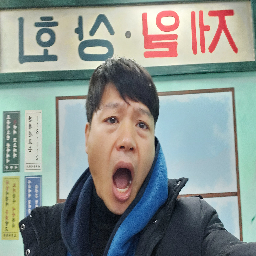

In [104]:
test_img[7]

In [ ]:
# df = pd.DataFrame(json_train, columns=['filename', 'faceExp_uploader'])
# df['faceExp_uploader'].unique()
# train_npz = np.load(TRAIN_SEGMENT_PATH + 'train_anger.npz')
# file_name = json_train[0]['filename']
# plt.imshow(train_npz[file_name], vmin=0, vmax=5)